In [2]:
!pip install findspark

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import numpy as np

import findspark
try:
    findspark.init()
except:
    PYSPARK_PATH = '../spark/spark-2.4.3-bin-hadoop2.7/' # change path to yours
    findspark.init(PYSPARK_PATH)
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

from pyspark.sql import *
from pyspark.sql.functions import col, lower, regexp_replace, split, size, UserDefinedFunction
from pyspark.sql.types import StringType, IntegerType
from functools import reduce
import re

from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.feature import PCA
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler

# Get CSV with features

In [23]:
# df_path = "csv_data/top-10-sample-output-ores_features.csv"
df_path = "csv_data/sample-output-ores_features.csv"
df_features = spark.read.csv(df_path, inferSchema=True, header=True, multiLine=True, escape='"')

### Select features for clusstering:

In [24]:
features_names = ['title',
                  'Stub',
                  'Start',
                  'C',
                  'B',
                  'GA',
                  'FA',
                  'n_words',
                  'level2',
                  'level3',
                  'level4',
                  'level5',
                  'level6',
                  'book_citations',
                  'journal_citations',
                  'n_internal_links',
                  'n_external_links',
                  'n_paragraphs',
                  'n_unreferenced',
                  'n_categories',
                  'n_images'
                 ]

### Vectorize features for scaling and clusstering

In [27]:
vectorAssembler = VectorAssembler(inputCols=features_names[1:],
                                  outputCol="features")

df_features = vectorAssembler.setHandleInvalid("skip").transform(df_features)

# Scaling:

In [7]:
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

# Compute summary statistics and generate MinMaxScalerModel
scalerModel = scaler.fit(df_features)

# rescale each feature to range [min, max].
scaled_features = scalerModel.transform(df_features)
scaled_features = scaled_features.select('scaled_features')

In [8]:
scaled_features.printSchema()
# scaled_features.limit(20).collect()

root
 |-- scaled_features: vector (nullable = true)



# Classtering K-means

In [75]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

k_means_costs = []
k_means_models = dict()
for count_classters in range(2, 15):
    kmeans = KMeans(featuresCol='scaled_features').setK(count_classters).setSeed(1)
    model = kmeans.fit(scaled_features)
    k_means_models[count_classters] = model
    cost = model.computeCost(scaled_features)
    k_means_costs.append(cost)
    print(f"Clussters: {count_classters} \t|\t Within Set Sum of Squared Errors = " + str(cost))

Clussters: 2 	|	 Within Set Sum of Squared Errors = 6743.854159398316
Clussters: 3 	|	 Within Set Sum of Squared Errors = 4216.573134644091
Clussters: 4 	|	 Within Set Sum of Squared Errors = 2765.4022573073185
Clussters: 5 	|	 Within Set Sum of Squared Errors = 2211.787909579115
Clussters: 6 	|	 Within Set Sum of Squared Errors = 1962.252490234855
Clussters: 7 	|	 Within Set Sum of Squared Errors = 1743.4626561118935
Clussters: 8 	|	 Within Set Sum of Squared Errors = 1531.0731986673127
Clussters: 9 	|	 Within Set Sum of Squared Errors = 1296.1192294855823
Clussters: 10 	|	 Within Set Sum of Squared Errors = 1331.5792058313532
Clussters: 11 	|	 Within Set Sum of Squared Errors = 1159.7811947194255
Clussters: 12 	|	 Within Set Sum of Squared Errors = 1089.8596427081172
Clussters: 13 	|	 Within Set Sum of Squared Errors = 1046.1003104502777
Clussters: 14 	|	 Within Set Sum of Squared Errors = 1013.1377177772889


In [76]:
bisect_k_means_costs = []
bisect_k_means_models = dict()
for count_classters in range(2, 15):
    bisect_kmeans = BisectingKMeans(featuresCol='scaled_features').setK(count_classters).setSeed(10)
    model = bisect_kmeans.fit(scaled_features)
    bisect_k_means_models[count_classters] = model
    cost = model.computeCost(scaled_features)
    bisect_k_means_costs.append(cost)
    print(f"Clussters: {count_classters} \t|\t Within Set Sum of Squared Errors = " + str(cost))

Clussters: 2 	|	 Within Set Sum of Squared Errors = 6743.854107299026
Clussters: 3 	|	 Within Set Sum of Squared Errors = 5030.754489988436
Clussters: 4 	|	 Within Set Sum of Squared Errors = 3981.496566508788
Clussters: 5 	|	 Within Set Sum of Squared Errors = 2539.8477297390477
Clussters: 6 	|	 Within Set Sum of Squared Errors = 2520.7990979127176
Clussters: 7 	|	 Within Set Sum of Squared Errors = 2348.0792400710943
Clussters: 8 	|	 Within Set Sum of Squared Errors = 2322.3197994420375
Clussters: 9 	|	 Within Set Sum of Squared Errors = 2318.6194949576147
Clussters: 10 	|	 Within Set Sum of Squared Errors = 1997.8797275968736
Clussters: 11 	|	 Within Set Sum of Squared Errors = 1654.3546230134573
Clussters: 12 	|	 Within Set Sum of Squared Errors = 1599.7312103925285
Clussters: 13 	|	 Within Set Sum of Squared Errors = 1580.4130225321414
Clussters: 14 	|	 Within Set Sum of Squared Errors = 1577.2828267891118


In [117]:
# predictions = k_means_models[2].transform(scaled_features).select('prediction')

In [148]:
# predictions = k_means_models[2].transform(scaled_features)# .select('prediction')

In [168]:
# predictions.cast("array<int>").dtypes
# qqq

In [167]:
# from pyspark.ml.evaluation import ClusteringEvaluator

# #predictions = bisect_k_means_models[2].transform(scaled_features)
# # predictions = k_means_models[2].transform(scaled_features) # .select('prediction')

# # Evaluate clustering by computing Silhouette score

# predictions = bisect_k_means_models[14].transform(scaled_features).select('prediction')
# vectorAssembler1 = VectorAssembler(inputCols=['prediction'],
#                                   outputCol="prediction_new")

# qqq = vectorAssembler1.setHandleInvalid("skip").transform(predictions)

# evaluator = ClusteringEvaluator(featuresCol='prediction_new')

# silhouette = evaluator.evaluate(qqq)
# print("Silhouette with squared euclidean distance = " + str(silhouette))


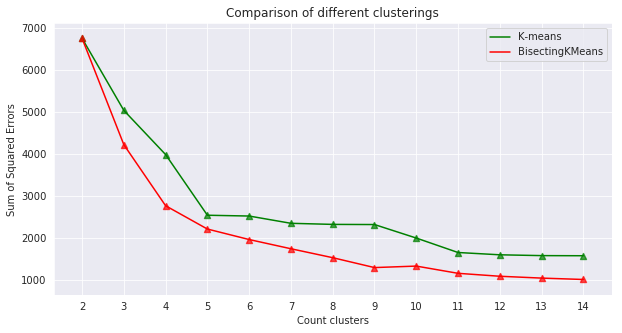

In [81]:
plt.figure(figsize=(10, 5))
plt.plot(range(2, 15), bisect_k_means_costs, color='green')
plt.scatter(range(2, 15), bisect_k_means_costs, color='green', marker='^', alpha=0.7, linewidths=1.4)

plt.plot(range(2, 15), k_means_costs, color='red')
plt.scatter(range(2, 15), k_means_costs, color='red', marker='^', alpha=0.7, linewidths=1.4)

plt.xlabel('Count clusters')
plt.ylabel('Sum of Squared Errors')
plt.title('Comparison of different clusterings')
plt.legend(['K-means', 'BisectingKMeans'])
plt.xticks(range(2, 15))
plt.show()

In [210]:
def get_pca_for_visualise(clusstering_model):
    labels = clusstering_model.transform(scaled_features).select('prediction')
    labels = labels.collect() 
    labels = list(map(lambda x: x.prediction, labels))
    # print(set(labels))

    pca = PCA(k=2, inputCol="scaled_features", outputCol="pcaFeatures")
    model = pca.fit(scaled_features)

    compressed = model.transform(scaled_features).select("pcaFeatures")
    compressed = compressed.toPandas()
    compressed.pcaFeatures = compressed.pcaFeatures.apply(lambda x: np.array(x))
    compressed = compressed.pcaFeatures.values
    compressed = np.stack(compressed, axis=0)

    colors = {0: 'red', 1: 'green', 2: 'blue', 3: 'pink', 4:'orange', 5:'yellow'}
    colors = list(map(lambda x: colors[x], labels))
    return compressed.T, colors

# K-means:

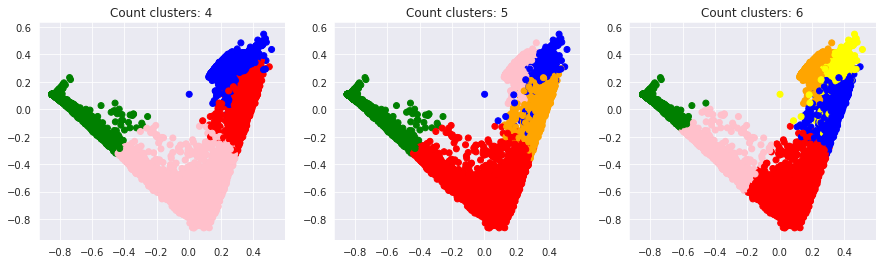

In [220]:
plt.figure(figsize=(15, 4))

points, colors = get_pca_for_visualise(k_means_models[4])
plt.subplot(1, 3, 1)
plt.scatter(*points, c=colors)
plt.title('Count clusters: ' + str(4))
#plt.show()

points, colors = get_pca_for_visualise(k_means_models[5])
plt.subplot(1, 3, 2)
plt.scatter(*points, c=colors)
plt.title('Count clusters: ' + str(5))
#plt.show()

points, colors = get_pca_for_visualise(k_means_models[6])
plt.subplot(1, 3, 3)
plt.scatter(*points, c=colors)
plt.title('Count clusters: ' + str(6))

plt.show()

# Bisect K-means:

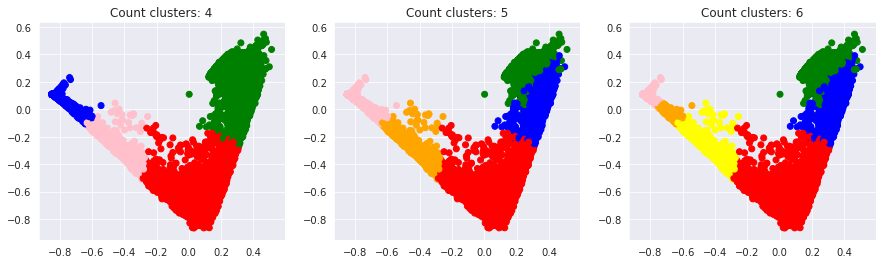

In [221]:
plt.figure(figsize=(15, 4))

points, colors = get_pca_for_visualise(bisect_k_means_models[4])
plt.subplot(1, 3, 1)
plt.scatter(*points, c=colors)
plt.title('Count clusters: ' + str(4))
#plt.show()

points, colors = get_pca_for_visualise(bisect_k_means_models[5])
plt.subplot(1, 3, 2)
plt.scatter(*points, c=colors)
plt.title('Count clusters: ' + str(5))
#plt.show()

points, colors = get_pca_for_visualise(bisect_k_means_models[6])
plt.subplot(1, 3, 3)
plt.scatter(*points, c=colors)
plt.title('Count clusters: ' + str(6))

plt.show()

# t-SNE

In [238]:
import pandas as pd
df_data_for_tsne = df_features.toPandas()[features_names[1:]]

In [239]:
from sklearn.manifold import TSNE
embedded_tsne = TSNE(n_components=2).fit_transform(df_data_for_tsne.values)

In [268]:
import matplotlib._color_data as mcd
len(mcd.CSS4_COLORS.keys())
def colors_for_tsne(clusstering_model):
    labels = clusstering_model.transform(scaled_features).select('prediction')
    labels = labels.collect() 
    labels = list(map(lambda x: x.prediction, labels))
    # colors = {0: 'red', 1: 'green', 2: 'blue', 3: 'pink', 4:'orange', 5:'yellow'}
    colors = dict(zip(range(len(list(mcd.CSS4_COLORS.keys())[20:] )), list(mcd.CSS4_COLORS.keys())[20:] ))
    colors = list(map(lambda x: colors[x], labels))
    
    return colors

# K-means on t-SNE

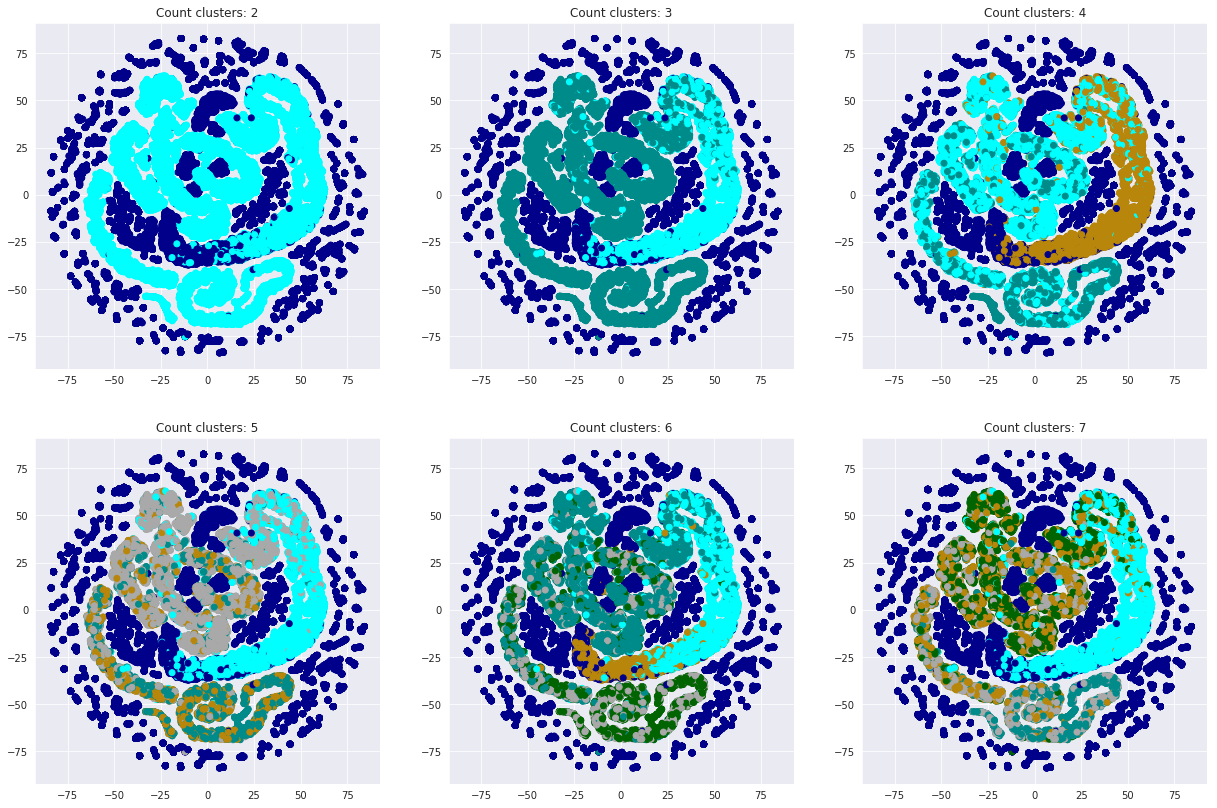

In [269]:
plt.figure(figsize=(21,14))

plt.subplot(2, 3, 1)
colors = colors_for_tsne(k_means_models[2])
plt.scatter(*embedded_tsne.T, c=colors)
plt.title('Count clusters: ' + str(2))

plt.subplot(2, 3, 2)
colors = colors_for_tsne(k_means_models[3])
plt.scatter(*embedded_tsne.T, c=colors)
plt.title('Count clusters: ' + str(3))

plt.subplot(2, 3, 3)
colors = colors_for_tsne(k_means_models[4])
plt.scatter(*embedded_tsne.T, c=colors)
plt.title('Count clusters: ' + str(4))

plt.subplot(2, 3, 4)
colors = colors_for_tsne(k_means_models[5])
plt.scatter(*embedded_tsne.T, c=colors)
plt.title('Count clusters: ' + str(5))

plt.subplot(2, 3, 5)
colors = colors_for_tsne(k_means_models[6])
plt.scatter(*embedded_tsne.T, c=colors)
plt.title('Count clusters: ' + str(6))

plt.subplot(2, 3, 6)
colors = colors_for_tsne(k_means_models[7])
plt.scatter(*embedded_tsne.T, c=colors)
plt.title('Count clusters: ' + str(7))

plt.show()

# Bisect K-means on t-SNE

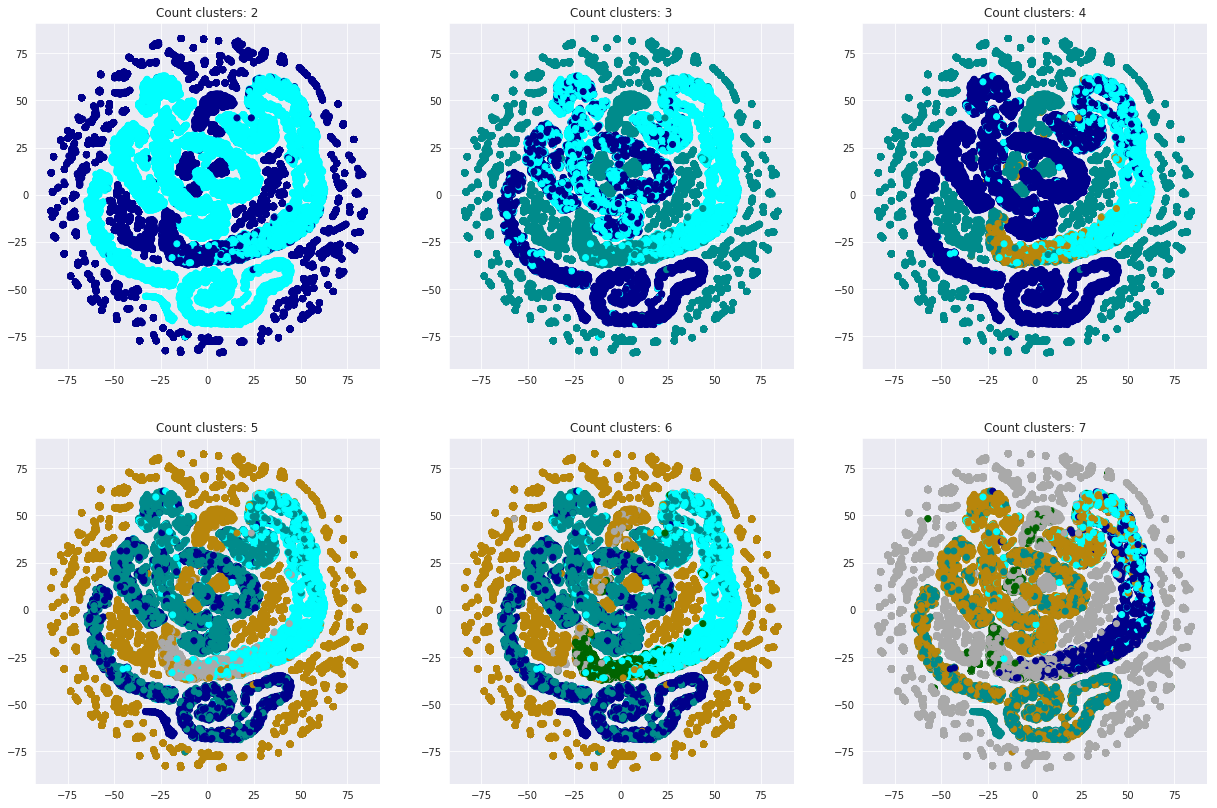

In [270]:
plt.figure(figsize=(21,14))

plt.subplot(2, 3, 1)
colors = colors_for_tsne(bisect_k_means_models[2])
plt.scatter(*embedded_tsne.T, c=colors)
plt.title('Count clusters: ' + str(2))

plt.subplot(2, 3, 2)
colors = colors_for_tsne(bisect_k_means_models[3])
plt.scatter(*embedded_tsne.T, c=colors)
plt.title('Count clusters: ' + str(3))

plt.subplot(2, 3, 3)
colors = colors_for_tsne(bisect_k_means_models[4])
plt.scatter(*embedded_tsne.T, c=colors)
plt.title('Count clusters: ' + str(4))

plt.subplot(2, 3, 4)
colors = colors_for_tsne(bisect_k_means_models[5])
plt.scatter(*embedded_tsne.T, c=colors)
plt.title('Count clusters: ' + str(5))

plt.subplot(2, 3, 5)
colors = colors_for_tsne(bisect_k_means_models[6])
plt.scatter(*embedded_tsne.T, c=colors)
plt.title('Count clusters: ' + str(6))

plt.subplot(2, 3, 6)
colors = colors_for_tsne(bisect_k_means_models[7])
plt.scatter(*embedded_tsne.T, c=colors)
plt.title('Count clusters: ' + str(7))

plt.show()

# OUTPUT: 

In [ ]:
k_means_models[3], bisect_k_means_models[3]  


In [9]:
# Trains a bisecting k-means model.
bkm = BisectingKMeans(featuresCol='scaled_features').setK(3).setSeed(1)
model = bkm.fit(scaled_features)

# Evaluate clustering.
cost = model.computeCost(scaled_features)
print("Within Set Sum of Squared Errors = " + str(cost))

# Shows the result. 
print("Cluster Centers: ")
centers = model.clusterCenters()
for center in centers:
    print(center)

Within Set Sum of Squared Errors = 4334.322907773121
Cluster Centers: 
[4.41816342e-03 6.05871560e-02 4.21633284e-01 3.38226916e-01
 1.75860719e-01 1.33750949e-01 1.17404751e-01 6.27008492e-02
 3.01234662e-02 1.36211793e-02 2.09925492e-03 3.30402804e-04
 1.92161040e-02 1.08397259e-02 6.27340914e-02 3.51979696e-02
 9.14101683e-02 5.57199263e-03 3.70502802e-02 5.00000000e-01]
[1.03776352e-01 6.99572954e-01 2.02840145e-01 1.16077459e-01
 1.50231342e-02 5.88593182e-03 1.57850163e-02 2.51075234e-02
 8.53901939e-03 1.17022045e-02 4.14533041e-04 2.28602780e-04
 1.64920577e-03 4.38345830e-04 1.82235869e-02 2.33599902e-03
 1.99008041e-02 2.53795739e-04 1.11765796e-02 5.00000000e-01]
[9.23316569e-01 7.39366382e-02 8.38966812e-03 9.59163034e-03
 1.71153937e-03 1.26769030e-03 1.38980849e-03 2.92297845e-03
 7.12543104e-04 8.96799277e-04 2.08737763e-06 0.00000000e+00
 1.16296754e-04 2.70054481e-05 1.51846050e-03 1.81758052e-04
 2.92170157e-03 2.65182158e-05 1.22808903e-03 5.00000000e-01]


In [10]:
# get predictions and collect into the list
labels = model.transform(scaled_features).select('prediction')
labels = labels.collect() 
# create vanilla list with ints 
# instead of list with element type Rows
labels = list(map(lambda x: x.prediction, labels))

In [11]:
"""
Visualization with PCA
"""
pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(df_features)

compressed = model.transform(df_features).select("pcaFeatures")
compressed.show(10)

+--------------------+
|         pcaFeatures|
+--------------------+
|[19884.2845406643...|
|[2141.58231948718...|
|[10819.1366918810...|
|[5274.36298090202...|
|[3033.26827065264...|
|[1790.08541020889...|
|[4679.62819741169...|
|[4881.89004518290...|
|[3326.15906935333...|
|[865.210217783942...|
+--------------------+
only showing top 10 rows



In [12]:
compressed = compressed.toPandas()
compressed.pcaFeatures = compressed.pcaFeatures.apply(lambda x: np.array(x))
compressed = compressed.pcaFeatures.values
compressed = np.stack(compressed, axis=0)

In [13]:
colors = {0: 'red', 1: 'green', 2: 'blue'}
colors = list(map(lambda x: colors[x], labels))

In [14]:
import seaborn as sns
sns.set_style('darkgrid')
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15,10)
mpl.rcParams['image.cmap'] = 'inferno'

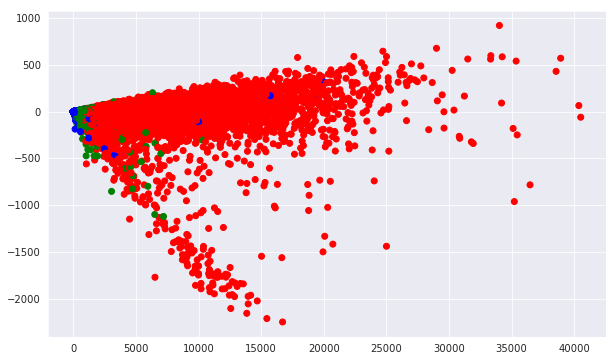

In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(*compressed.T, c=colors)